In [1]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=10,threads_per_worker=10,processes=True)
client

/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33225 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:37075' processes=10 threads=100, memory=67.54 GB>

In [2]:
import xarray as xr
import numpy as np
import os

In [3]:
import warnings
warnings.simplefilter("ignore")

In [4]:
# file name setting
mip_era = 'CMIP6'
activity_drs = 'CMIP'
institution_id = 'E3SM-Project'
source_id = 'E3SM-1-0'
experiment_id = 'historical'
member_id = 'r1i1p1f1'
grid_label = 'gr'
version = '1'

In [5]:
ocn_data_vars = ['tos','areacello']

ocn_data_tables = ['Omon','Ofx']

data_paths = {}
data_files = {}

for i in range(len(ocn_data_vars)):
    data_paths[ocn_data_vars[i]] = os.path.join('/maloney-scratch/joedhsu/proj1/data/CMIP6',mip_era,activity_drs,institution_id,
                                                 source_id,experiment_id,member_id,
                                                 ocn_data_tables[i],ocn_data_vars[i],grid_label,version)
    data_files[ocn_data_vars[i]] = '%s_%s_%s_%s_%s_%s_*.nc'%(ocn_data_vars[i],
                                                                     ocn_data_tables[i],
                                                                     source_id,
                                                                     experiment_id,
                                                                     member_id,
                                                                     grid_label)  
    
for nvar,var in enumerate(ocn_data_vars):
    if var in ['areacello']:
        ds_temp = xr.open_dataset(os.path.join(data_paths[var],data_files[var][:-5]+'.nc'),
                             chunks={'lat':100,'lon':100})
    else: 
        ds_temp = xr.open_mfdataset(os.path.join(data_paths[var],data_files[var]),
                             chunks={'time':100,'lat':100,'lon':100})
    if nvar == 0:
        ds_ocn = ds_temp.copy()
    else:
        ds_ocn = xr.merge([ds_ocn,ds_temp])

In [6]:
cmip6_time = xr.cftime_range(start='1850-01-01', end='2014-12-01', freq='MS', calendar='noleap')
ds_ocn['time'] = cmip6_time

In [7]:
ds_ocn

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 360, time: 1980)
Coordinates:
  * time       (time) object 1850-01-01 00:00:00 ... 2014-12-01 00:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1980, 100, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1980, 100, 2), meta=np.ndarray>
    tos        (time, lat, lon) float32 dask.array<chunksize=(60, 100, 100), meta=np.ndarray>
    areacello  (lat, lon) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>

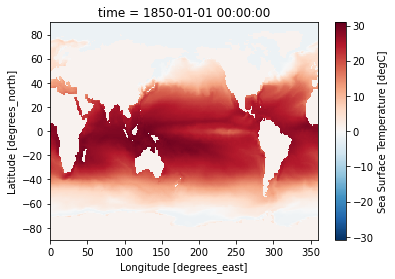

In [8]:
ds_ocn.tos.isel(time=0).plot(x='lon',y='lat')

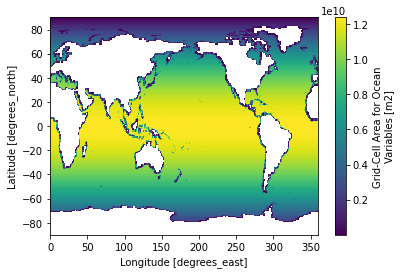

In [9]:
ds_ocn.areacello.plot()

In [ ]:
# import importlib.util
# spec = importlib.util.spec_from_file_location("cal_oni", "/home/joedhsu/proj1/MJO_fluxes/cal_oni.py")
# cal_oni = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(cal_oni)

import importlib
import cal_oni
importlib.reload(cal_oni)
from cal_oni import model_oni

da_oni = model_oni(ds_ocn.tos,area_weight=ds_ocn.areacello)

Text(0.5, 1.0, 'E3SM-1-0 historical')

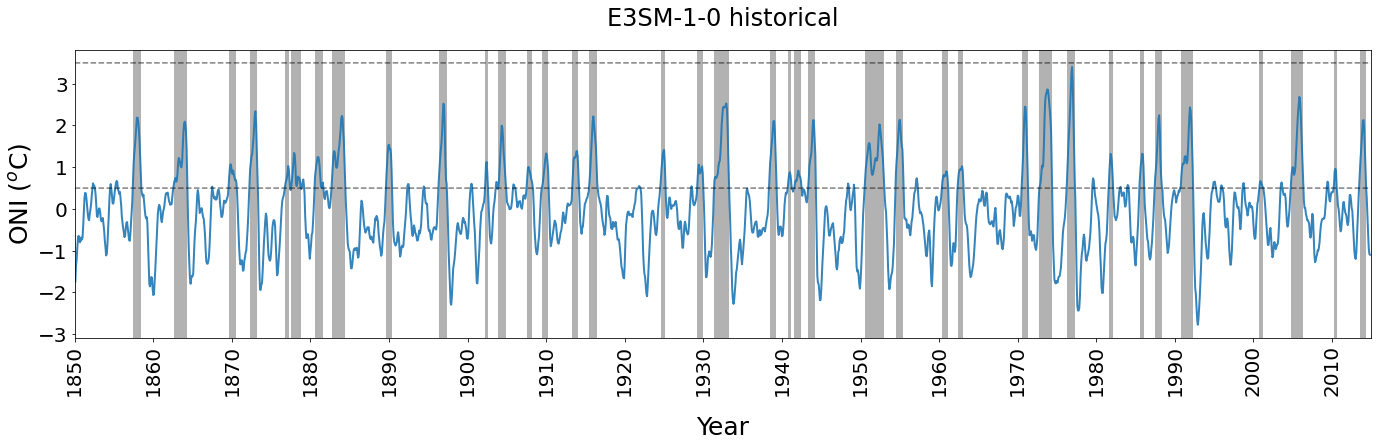

In [12]:
# import pandas as pd
# import datetime
# table1=pd.read_csv('/storage1/home1/chiaweih/Research/proj1_enso_temp/data/Hist_ONI_cpc_noaa.txt',sep='\s+',header=1)
# nrow,ncol=table1.shape
# date=[datetime.datetime(table1['YR'].values[i], table1['MON'].values[i],1) for i in range(nrow)]
# da_oni_cpc=xr.DataArray(table1['ANOM'].values,coords={'time':date},dims='time')

elnino_crit_lower=0.5
elnino_crit_max=3.5
elnino_crit_min=0.5
elnino_cont_mon=5


#### identify monthly El Nino event
da_elnino=da_oni.copy()
da_elnino.values[da_elnino<elnino_crit_lower]+=np.nan

#### counting total El Nino events
da_elnino_crit=da_elnino.copy()+np.nan
elnino_event_count=0
event_length=0
temp_ind=[]
for kk in range(len(da_elnino)):
    if da_elnino.values[kk] > 0. :
        event_length+=1
        temp_ind.append(kk)
    else:
        if event_length>=elnino_cont_mon: 
            if elnino_crit_max and elnino_crit_min:
                # 3 month mean for all available continuous El Nino months
                da_temp=da_elnino[temp_ind].rolling(dim={"time":3},min_periods=3,center=True).mean()
                ##print da_temp.max(),da_elnino[temp_ind].time.values[0]
                # any 3 month mean lower than the critical max value and larger than critical min value
                # will be catagorized accordingly
                if da_temp.max() <= elnino_crit_max and da_temp.max() >= elnino_crit_min :
                    elnino_event_count+=1
                    da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            elif elnino_crit_max is None and  elnino_crit_min is None:
                elnino_event_count+=1
                da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            else:
                sys.exit('please put both min and max El Nino Criterias or else put both as None')

        temp_ind=[]
        event_length=0 

import matplotlib.transforms as mtransforms     
import matplotlib.pyplot as plt
#### plotting
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
ax1color='k'

# elnino_crit_max = 3
# elnino_crit_min = 0.5

modelname=['E3SM-1-0']
model_legend_name = ['E3SM-1-0']
modelcolor=['C0']

da_oni.plot(ax=ax1,
            label=model_legend_name[0],
            linewidth=2.0,
            color=modelcolor[0],
            alpha=0.9)
    
# da_oni_cpc.plot(ax=ax1,label="CPC",color=ax1color,linestyle='--')

# da_elnino_crit = da_oni.where(da_oni>=0.5)
#### plot event
if elnino_crit_max and elnino_crit_min:
    elnino_low_line=np.zeros(len(da_oni))+elnino_crit_min
    elnino_max_line=np.zeros(len(da_oni))+elnino_crit_max
    ax1.plot(da_oni.time.values,elnino_low_line,color=ax1color,linestyle='dashed',alpha=0.5)
    ax1.plot(da_oni.time.values,elnino_max_line,color=ax1color,linestyle='dashed',alpha=0.5)
trans = mtransforms.blended_transform_factory(ax1.transData, ax1.transAxes)
ax1.fill_between(da_oni.time.values,0,1\
                 ,where=da_elnino_crit.notnull(),facecolor=ax1color, alpha=0.3, transform=trans)

#### setting the plotting format
ax1.set_ylabel('ONI ($^o$C)',{'size':'25'},color='k')
ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
ax1.set_xlim([da_oni.time.values[0],da_oni.time.values[-1]])
ax1.set_xticks(da_oni.time.values[::10*12])
ax1.set_xticklabels(["%0.1i"%(date.year) for date in da_oni.time.values[::10*12]])
ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
ax1.set_title("E3SM-1-0 historical",{'size':'24'},pad=24)
# ax1.legend(loc='upper left',fontsize=14,frameon=False)
# ax1.grid(linestyle='dashed')

# E3SM daily

In [64]:
import importlib
import io_model
importlib.reload(io_model)
from io_model import E3SM_daily_cori_io_sst

# 0-360
lon_lim = [0,360]
lat_lim = [-90,90]

ds_e3sm = E3SM_daily_cori_io_sst(lon_lim,lat_lim,case='11years').compute()


/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h1.????-??-??-00000.nc
/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h1.????-??-??-00000.nc
/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h1.????-??-??-00000.nc
/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont3.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365_cont3.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h1.????-??-??-00000.nc
/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont4.A_WCYCL20TRS_C

In [65]:
ds_e3sm

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 4015)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 2000-01-02 00:00:00 ... 2011-01-01 00:00:00
Data variables:
    SST      (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 271.4 271.4 271.4

In [66]:
# resample from daily to monthly
da_e3sm_ts_mon = ds_e3sm.resample(time='MS',keep_attrs=True).mean()

In [67]:
da_e3sm_ts_mon['SST'] = da_e3sm_ts_mon.SST.where(da_e3sm_ts_mon.SST>273,other=np.nan)-273.15

In [68]:
# import importlib.util
# spec = importlib.util.spec_from_file_location("cal_oni", "/home/joedhsu/proj1/MJO_fluxes/cal_oni.py")
# cal_oni = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(cal_oni)

import importlib
import cal_oni
importlib.reload(cal_oni)
from cal_oni import model_oni

da_oni_rerun = model_oni(da_e3sm_ts_mon.SST,area_weight=None,remove_30mean=False)

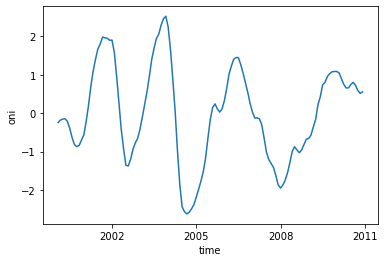

In [69]:
da_oni_rerun.plot()

Text(0.5, 1.0, 'E3SM-1-0 2000 restart')

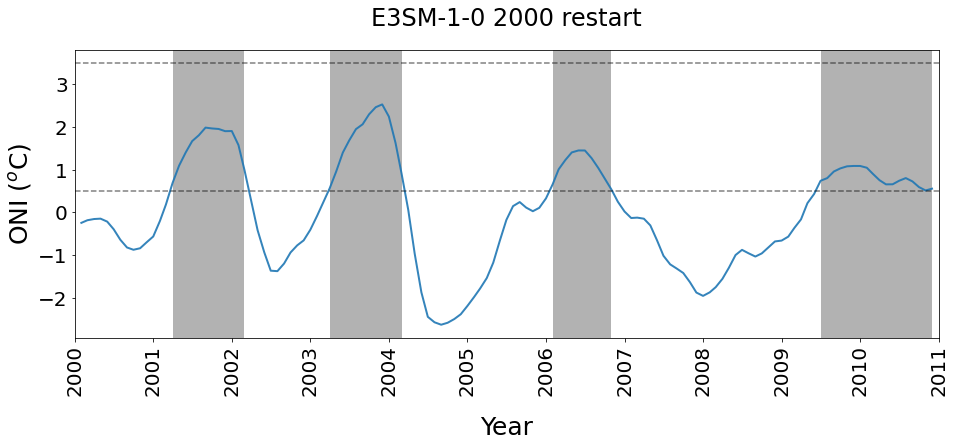

In [70]:
# import pandas as pd
# import datetime
# table1=pd.read_csv('/storage1/home1/chiaweih/Research/proj1_enso_temp/data/Hist_ONI_cpc_noaa.txt',sep='\s+',header=1)
# nrow,ncol=table1.shape
# date=[datetime.datetime(table1['YR'].values[i], table1['MON'].values[i],1) for i in range(nrow)]
# da_oni_cpc=xr.DataArray(table1['ANOM'].values,coords={'time':date},dims='time')

elnino_crit_lower=0.5
elnino_crit_max=3.5
elnino_crit_min=0.5
elnino_cont_mon=5


#### identify monthly El Nino event
da_elnino=da_oni_rerun.copy()
da_elnino.values[da_elnino<elnino_crit_lower]+=np.nan

#### counting total El Nino events
da_elnino_crit=da_elnino.copy()+np.nan
elnino_event_count=0
event_length=0
temp_ind=[]
for kk in range(len(da_elnino)):
    if da_elnino.values[kk] > 0. :
        event_length+=1
        temp_ind.append(kk)
    else:
        if event_length>=elnino_cont_mon: 
            if elnino_crit_max and elnino_crit_min:
                # 3 month mean for all available continuous El Nino months
                da_temp=da_elnino[temp_ind].rolling(dim={"time":3},min_periods=3,center=True).mean()
                ##print da_temp.max(),da_elnino[temp_ind].time.values[0]
                # any 3 month mean lower than the critical max value and larger than critical min value
                # will be catagorized accordingly
                if da_temp.max() <= elnino_crit_max and da_temp.max() >= elnino_crit_min :
                    elnino_event_count+=1
                    da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            elif elnino_crit_max is None and  elnino_crit_min is None:
                elnino_event_count+=1
                da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            else:
                sys.exit('please put both min and max El Nino Criterias or else put both as None')

        temp_ind=[]
        event_length=0 

import matplotlib.transforms as mtransforms     
import matplotlib.pyplot as plt
#### plotting
fig=plt.figure(1)
ax1=fig.add_axes([0,0,2,1])
ax1color='k'

# elnino_crit_max = 3
# elnino_crit_min = 0.5

modelname=['E3SM-1-0']
model_legend_name = ['E3SM-1-0-restart2000']
modelcolor=['C0']

da_oni_rerun.plot(ax=ax1,
            label=model_legend_name[0],
            linewidth=2.0,
            color=modelcolor[0],
            alpha=0.9)
    
# da_oni_cpc.plot(ax=ax1,label="CPC",color=ax1color,linestyle='--')

# da_elnino_crit = da_oni.where(da_oni>=0.5)
#### plot event
if elnino_crit_max and elnino_crit_min:
    elnino_low_line=np.zeros(len(da_oni_rerun))+elnino_crit_min
    elnino_max_line=np.zeros(len(da_oni_rerun))+elnino_crit_max
    ax1.plot(da_oni_rerun.time.values,elnino_low_line,color=ax1color,linestyle='dashed',alpha=0.5)
    ax1.plot(da_oni_rerun.time.values,elnino_max_line,color=ax1color,linestyle='dashed',alpha=0.5)
trans = mtransforms.blended_transform_factory(ax1.transData, ax1.transAxes)
ax1.fill_between(da_oni_rerun.time.values,0,1\
                 ,where=da_elnino_crit.notnull(),facecolor=ax1color, alpha=0.3, transform=trans)

#### setting the plotting format
ax1.set_ylabel('ONI ($^o$C)',{'size':'25'},color='k')
ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
ax1.set_xlim([da_oni_rerun.time.values[0],da_oni_rerun.time.values[-1]])
ax1.set_xticks(da_oni_rerun.time.values[::12])
ax1.set_xticklabels(["%0.1i"%(date.year) for date in da_oni_rerun.time.values[::12]])
ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
ax1.set_title("E3SM-1-0 2000 restart",{'size':'24'},pad=24)
# ax1.legend(loc='upper left',fontsize=14,frameon=False)
# ax1.grid(linestyle='dashed')

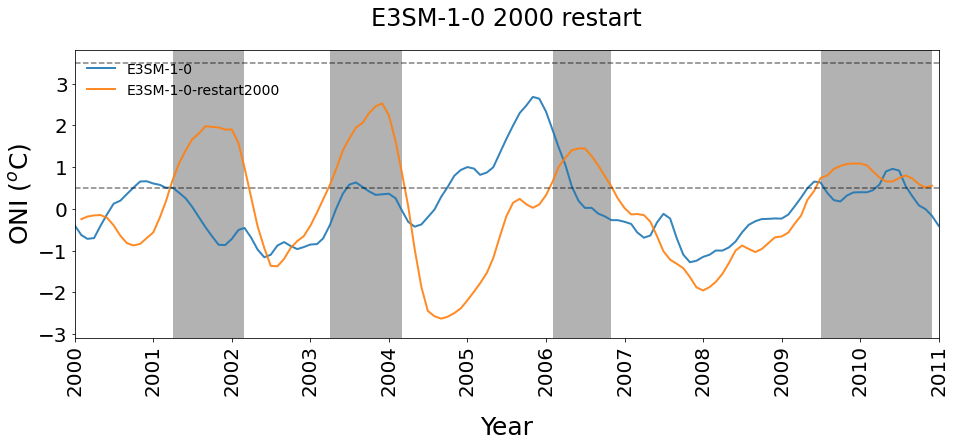

In [71]:
# import pandas as pd
# import datetime
# table1=pd.read_csv('/storage1/home1/chiaweih/Research/proj1_enso_temp/data/Hist_ONI_cpc_noaa.txt',sep='\s+',header=1)
# nrow,ncol=table1.shape
# date=[datetime.datetime(table1['YR'].values[i], table1['MON'].values[i],1) for i in range(nrow)]
# da_oni_cpc=xr.DataArray(table1['ANOM'].values,coords={'time':date},dims='time')

elnino_crit_lower=0.5
elnino_crit_max=3.5
elnino_crit_min=0.5
elnino_cont_mon=5


#### identify monthly El Nino event
da_elnino=da_oni_rerun.copy()
da_elnino.values[da_elnino<elnino_crit_lower]+=np.nan

#### counting total El Nino events
da_elnino_crit=da_elnino.copy()+np.nan
elnino_event_count=0
event_length=0
temp_ind=[]
for kk in range(len(da_elnino)):
    if da_elnino.values[kk] > 0. :
        event_length+=1
        temp_ind.append(kk)
    else:
        if event_length>=elnino_cont_mon: 
            if elnino_crit_max and elnino_crit_min:
                # 3 month mean for all available continuous El Nino months
                da_temp=da_elnino[temp_ind].rolling(dim={"time":3},min_periods=3,center=True).mean()
                ##print da_temp.max(),da_elnino[temp_ind].time.values[0]
                # any 3 month mean lower than the critical max value and larger than critical min value
                # will be catagorized accordingly
                if da_temp.max() <= elnino_crit_max and da_temp.max() >= elnino_crit_min :
                    elnino_event_count+=1
                    da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            elif elnino_crit_max is None and  elnino_crit_min is None:
                elnino_event_count+=1
                da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            else:
                sys.exit('please put both min and max El Nino Criterias or else put both as None')

        temp_ind=[]
        event_length=0 

import matplotlib.transforms as mtransforms     
import matplotlib.pyplot as plt
#### plotting
fig=plt.figure(1)
ax1=fig.add_axes([0,0,2,1])
ax1color='k'

# elnino_crit_max = 3
# elnino_crit_min = 0.5

modelname=['E3SM-1-0']
model_legend_name = ['E3SM-1-0','E3SM-1-0-restart2000']
modelcolor=['C0','C1']

da_oni.plot(ax=ax1,
            label=model_legend_name[0],
            linewidth=2.0,
            color=modelcolor[0],
            alpha=0.9)

da_oni_rerun.plot(ax=ax1,
            label=model_legend_name[1],
            linewidth=2.0,
            color=modelcolor[1],
            alpha=0.9)
    
# da_oni_cpc.plot(ax=ax1,label="CPC",color=ax1color,linestyle='--')

# da_elnino_crit = da_oni.where(da_oni>=0.5)
#### plot event
if elnino_crit_max and elnino_crit_min:
    elnino_low_line=np.zeros(len(da_oni_rerun))+elnino_crit_min
    elnino_max_line=np.zeros(len(da_oni_rerun))+elnino_crit_max
    ax1.plot(da_oni_rerun.time.values,elnino_low_line,color=ax1color,linestyle='dashed',alpha=0.5)
    ax1.plot(da_oni_rerun.time.values,elnino_max_line,color=ax1color,linestyle='dashed',alpha=0.5)
trans = mtransforms.blended_transform_factory(ax1.transData, ax1.transAxes)
ax1.fill_between(da_oni_rerun.time.values,0,1\
                 ,where=da_elnino_crit.notnull(),facecolor=ax1color, alpha=0.3, transform=trans)

#### setting the plotting format
ax1.set_ylabel('ONI ($^o$C)',{'size':'25'},color='k')
ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
ax1.set_xlim([da_oni_rerun.time.values[0],da_oni_rerun.time.values[-1]])
ax1.set_xticks(da_oni_rerun.time.values[::12])
ax1.set_xticklabels(["%0.1i"%(date.year) for date in da_oni_rerun.time.values[::12]])
ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
ax1.set_title("E3SM-1-0 2000 restart",{'size':'24'},pad=24)
ax1.legend(loc='upper left',fontsize=14,frameon=False)
# ax1.grid(linestyle='dashed')

In [92]:
import importlib
import io_model
importlib.reload(io_model)
from io_model import E3SM_daily_cori_io_dask

# 0-360
lon_lim = [0,360]
lat_lim = [-90,90]

ds_e3sm_flnt = E3SM_daily_cori_io_dask(lon_lim,lat_lim,varlist=['FLNT'],hist='h2',case='5years')

/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h2.????-??-??-00000.nc
/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h2.????-??-??-00000.nc
/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h2.????-??-??-00000.nc


In [94]:
ds_e3sm_flnt

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1825)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 2000-01-02 00:00:00 ... 2005-01-01 00:00:00
Data variables:
    FLNT     (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

In [90]:
varlist=['FLNT']
hist='h2'
case='5years'

if case in ['5years']:
    casename1 = '20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    casename2 = '20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    casename3 = '20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    totalcase = [casename1,casename2,casename3]
elif case in ['11years']:
    casename1 = '20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    casename2 = '20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    casename3 = '20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    casename4 = '20210501.HIST2000_365_cont3.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    casename5 = '20210501.HIST2000_365_cont4.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    totalcase = [casename1,casename2,casename3,casename4,casename5]
elif case in ['10years']:
    casename2 = '20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    casename3 = '20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    casename4 = '20210501.HIST2000_365_cont3.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    casename5 = '20210501.HIST2000_365_cont4.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
    totalcase = [casename2,casename3,casename4,casename5]
else :
    print('Please enter casename')

# file name setting
data_vars = varlist

da_list = []
for casename in totalcase:
    data_path = os.path.join('/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/',
                                            casename,
                                            'regrid')

    data_hist_files = '%s.cam.%s.????-??-??-00000.nc'%(casename,hist)

    print(os.path.join(data_path,data_hist_files))
    ds_atm_hist = xr.open_mfdataset(os.path.join(data_path,data_hist_files),
                                     chunks={'time':100,'lat':-1,'lon':-1})


    da_list1 = [ds_atm_hist[var] for var in data_vars]
    da_list = da_list+da_list1

ds_atm = xr.concat(da_list,dim='time')   # DataArray


/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h2.????-??-??-00000.nc
/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h2.????-??-??-00000.nc
/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h2.????-??-??-00000.nc


Exception ignored in: <function CachingFileManager.__del__ at 0x7fe0a4271ca0>
Traceback (most recent call last):
  File "/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xarray/backends/file_manager.py", line 224, in __del__
    def __del__(self):
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-2e8045fa3a84>", line 38, in <module>
    ds_atm_hist = xr.open_mfdataset(os.path.join(data_path,data_hist_files),
  File "/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xarray/backends/api.py", line 948, in open_mfdataset
    datasets = [open_(p, **open_kwargs) for p in paths]
  File "/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xarray/backends/api.py", line 948, in <listcomp>
    datasets = [open_(p, **open_kwargs) for p in paths]
  File "/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xarray/backends/api.py", line 575, in open_dataset
    ds = maybe_decode_store(store, chunks)
  File "/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xarray/backends/api.


KeyboardInterrupt



In [79]:
hist='h2'


casename1 = '20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
casename2 = '20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'
casename3 = '20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl'


data_path = os.path.join('/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/',
                                                casename1,
                                                'regrid')

data_hist_files = '%s.cam.%s.????-??-??-00000.nc'%(casename1,hist)

print(os.path.join(data_path,data_hist_files))
ds_atm_hist = xr.open_mfdataset(os.path.join(data_path,data_hist_files),
                                 chunks={'time':100,'lat':-1,'lon':-1})

/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365days.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h2.????-??-??-00000.nc


In [82]:
data_path = os.path.join('/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/',
                                                casename2,
                                                'regrid')

data_hist_files = '%s.cam.%s.????-??-??-00000.nc'%(casename2,hist)

print(os.path.join(data_path,data_hist_files))
ds_atm_hist2 = xr.open_mfdataset(os.path.join(data_path,data_hist_files),
                                 chunks={'time':100,'lat':-1,'lon':-1})

/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365_cont.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h2.????-??-??-00000.nc


In [86]:
data_path = os.path.join('/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/',
                                                casename3,
                                                'regrid')

data_hist_files = '%s.cam.%s.????-??-??-00000.nc'%(casename3,hist)

print(os.path.join(data_path,data_hist_files))
ds_atm_hist3 = xr.open_mfdataset(os.path.join(data_path,data_hist_files),
                                 chunks={'time':100,'lat':-1,'lon':-1})

/maloney-scratch/joedhsu/proj1/data/E3SM_simulation/20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl/regrid/20210501.HIST2000_365_cont2.A_WCYCL20TRS_CMIP6.ne30_oECv3_ICG.cori-knl.cam.h2.????-??-??-00000.nc


In [87]:
xr.concat([ds_atm_hist2.FLNT, ds_atm_hist.FLNT,ds_atm_hist3.FLNT],dim='time')

<xarray.DataArray 'FLNT' (time: 1825, lat: 180, lon: 360)>
dask.array<concatenate, shape=(1825, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 2001-01-02 00:00:00 ... 2005-01-01 00:00:00
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Net longwave flux at top of model
    cell_methods:       time: mean
    cell_measures:      area: area

In [ ]:
import importlib
import io_model
importlib.reload(io_model)
from io_model import E3SM_daily_cori_io_fast

# 0-360
lon_lim = [0,360]
lat_lim = [-90,90]

ds_e3sm = E3SM_daily_cori_io_fast(lon_lim,lat_lim,case='365test').SST.compute()


In [71]:
# resample from daily to monthly
da_e3sm_ts_mon = ds_e3sm.resample(time='MS',keep_attrs=True).mean()

In [75]:
da_e3sm_ts_mon = da_e3sm_ts_mon.where(da_e3sm_ts_mon>273,other=np.nan)-273.15

In [ ]:
# import importlib
# import io_model
# importlib.reload(io_model)
# from io_model import E3SM_daily_cori_io_fast

# # 0-360
# lon_lim = [180,-110+360]
# lat_lim = [-10,10]
# year_lim = [2000,2000]

# da_e3sm_ts = E3SM_daily_cori_io_fast(lon_lim,lat_lim,case='365test').SST.compute()

# # resample from daily to monthly
# da_e3sm_ts_mon = da_e3sm_ts.resample(time='MS',keep_attrs=True).mean()

# # from cal_oni import model_oni
# # da_e3sm_oni = model_oni(da_e3sm_ts_mon).compute()

# # # resample from monthly to daily
# # da_e3sm_oni_daily = da_e3sm_oni.resample(time="1D").interpolate("linear")

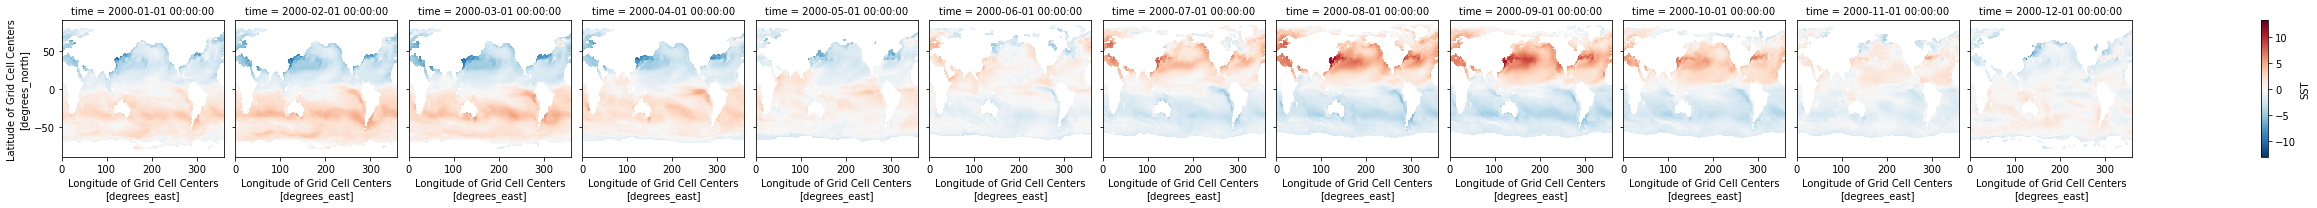

In [87]:
(da_e3sm_ts_mon.isel(time=slice(0,12))-da_e3sm_ts_mon.mean(dim='time')).plot(col='time')

In [88]:
da_new = da_e3sm_ts_mon.isel(time=slice(0,12))-da_e3sm_ts_mon.mean(dim='time')

In [42]:
ds_ocn_2000 = ds_ocn.tos.sel(time=slice("2000-01-01","2000-12-01")).compute()

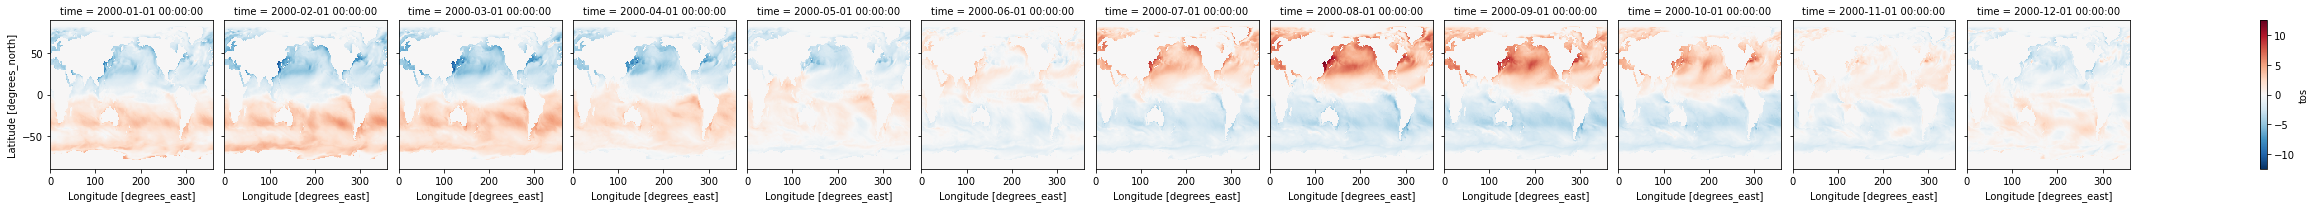

In [86]:
(ds_ocn_2000.isel(time=slice(0,12))-ds_ocn_2000.mean(dim='time')).plot(col='time')

In [89]:
da_old = ds_ocn_2000.isel(time=slice(0,12))-ds_ocn_2000.mean(dim='time')

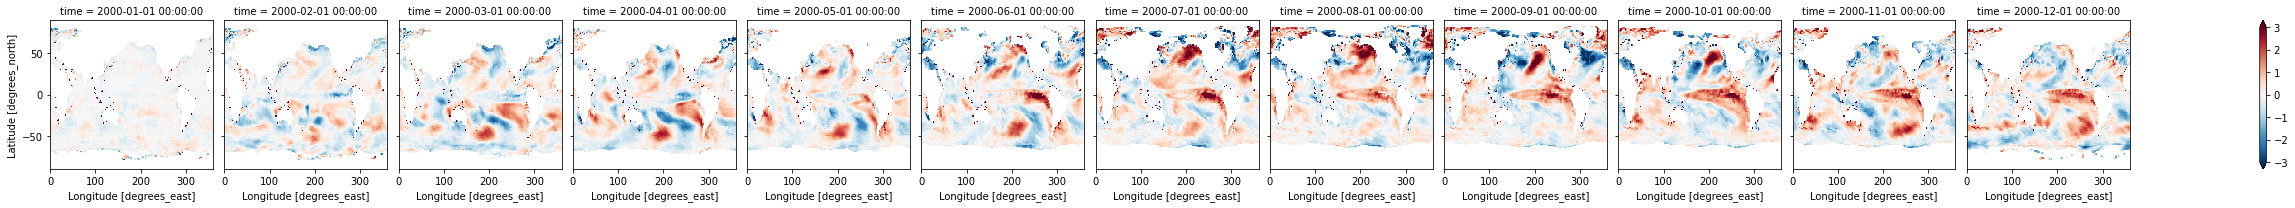

In [91]:
(ds_ocn_2000-da_e3sm_ts_mon).plot(col='time',vmin=-3,vmax=3,cmap='RdBu_r')

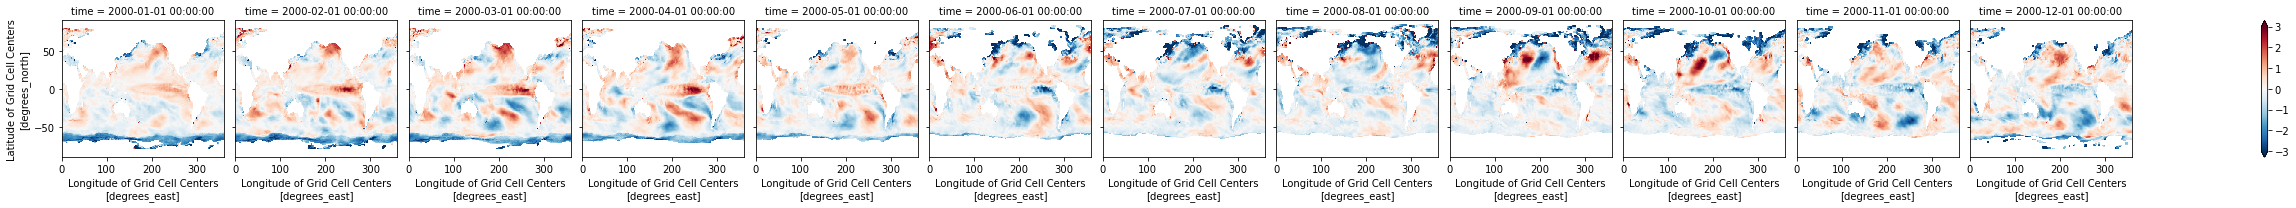

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [92]:
(da_new-da_old).plot(col='time',vmin=-3,vmax=3,cmap='RdBu_r')

Text(0.5, 1.0, 'E3SM daily')

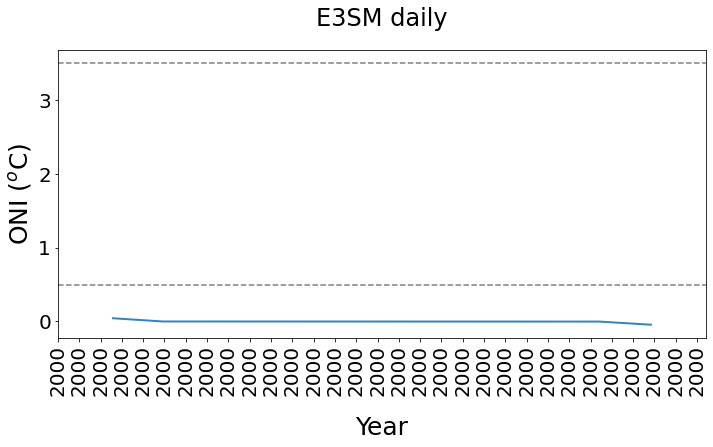

In [29]:
# import pandas as pd
# import datetime
# table1=pd.read_csv('/storage1/home1/chiaweih/Research/proj1_enso_temp/data/Hist_ONI_cpc_noaa.txt',sep='\s+',header=1)
# nrow,ncol=table1.shape
# date=[datetime.datetime(table1['YR'].values[i], table1['MON'].values[i],1) for i in range(nrow)]
# da_oni_cpc=xr.DataArray(table1['ANOM'].values,coords={'time':date},dims='time')

elnino_crit_lower=0.5
elnino_crit_max=3.5
elnino_crit_min=0.5
elnino_cont_mon=5


#### identify monthly El Nino event
da_elnino=da_e3sm_oni_daily.copy()
da_elnino.values[da_elnino<elnino_crit_lower]+=np.nan

#### counting total El Nino events
da_elnino_crit=da_elnino.copy()+np.nan
elnino_event_count=0
event_length=0
temp_ind=[]
for kk in range(len(da_elnino)):
    if da_elnino.values[kk] > 0. :
        event_length+=1
        temp_ind.append(kk)
    else:
        if event_length>=elnino_cont_mon: 
            if elnino_crit_max and elnino_crit_min:
                # 3 month mean for all available continuous El Nino months
                da_temp=da_elnino[temp_ind].rolling(dim={"time":3},min_periods=3,center=True).mean()
                ##print da_temp.max(),da_elnino[temp_ind].time.values[0]
                # any 3 month mean lower than the critical max value and larger than critical min value
                # will be catagorized accordingly
                if da_temp.max() <= elnino_crit_max and da_temp.max() >= elnino_crit_min :
                    elnino_event_count+=1
                    da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            elif elnino_crit_max is None and  elnino_crit_min is None:
                elnino_event_count+=1
                da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            else:
                sys.exit('please put both min and max El Nino Criterias or else put both as None')

        temp_ind=[]
        event_length=0 

import matplotlib.transforms as mtransforms     
import matplotlib.pyplot as plt
#### plotting
fig=plt.figure(1)
ax1=fig.add_axes([0,0,1.5,1])
ax1color='k'

# elnino_crit_max = 3
# elnino_crit_min = 0.5

modelname=['E3SM-1-0-restart2020']
model_legend_name = ['E3SM-1-0-restart2020']
modelcolor=['C0']

da_e3sm_oni_daily.plot(ax=ax1,
            label=model_legend_name[0],
            linewidth=2.0,
            color=modelcolor[0],
            alpha=0.9)
    
# da_oni_cpc.plot(ax=ax1,label="CPC",color=ax1color,linestyle='--')

# da_elnino_crit = da_oni.where(da_oni>=0.5)
#### plot event
if elnino_crit_max and elnino_crit_min:
    elnino_low_line=np.zeros(len(da_e3sm_oni_daily))+elnino_crit_min
    elnino_max_line=np.zeros(len(da_e3sm_oni_daily))+elnino_crit_max
    ax1.plot(da_e3sm_oni_daily.time.values,elnino_low_line,color=ax1color,linestyle='dashed',alpha=0.5)
    ax1.plot(da_e3sm_oni_daily.time.values,elnino_max_line,color=ax1color,linestyle='dashed',alpha=0.5)
trans = mtransforms.blended_transform_factory(ax1.transData, ax1.transAxes)
ax1.fill_between(da_e3sm_oni_daily.time.values,0,1\
                 ,where=da_elnino_crit.notnull(),facecolor=ax1color, alpha=0.3, transform=trans)

#### setting the plotting format
ax1.set_ylabel('ONI ($^o$C)',{'size':'25'},color='k')
ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
ax1.set_xlim([da_e3sm_oni_daily.time.values[0],da_e3sm_oni_daily.time.values[-1]])
ax1.set_xticks(da_e3sm_oni_daily.time.values[::12])
ax1.set_xticklabels(["%0.1i"%(date.year) for date in da_e3sm_oni_daily.time.values[::12]])
ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
ax1.set_title("E3SM daily",{'size':'24'},pad=24)
# ax1.legend(loc='upper left',fontsize=14,frameon=False)
# ax1.grid(linestyle='dashed')

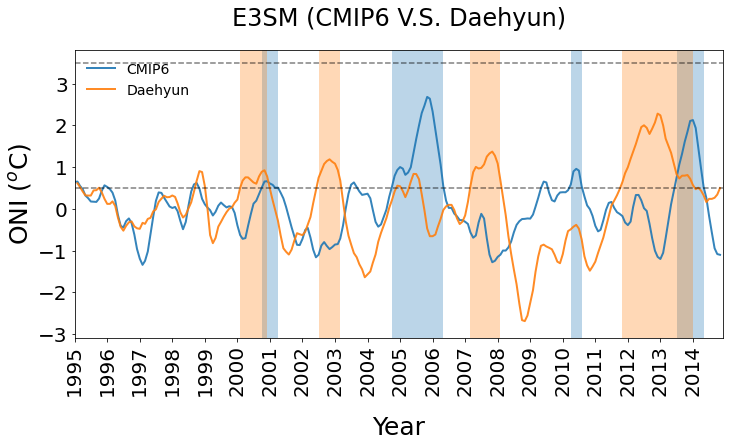

In [22]:
# import pandas as pd
# import datetime
# table1=pd.read_csv('/storage1/home1/chiaweih/Research/proj1_enso_temp/data/Hist_ONI_cpc_noaa.txt',sep='\s+',header=1)
# nrow,ncol=table1.shape
# date=[datetime.datetime(table1['YR'].values[i], table1['MON'].values[i],1) for i in range(nrow)]
# da_oni_cpc=xr.DataArray(table1['ANOM'].values,coords={'time':date},dims='time')

elnino_crit_lower=0.5
elnino_crit_max=3.5
elnino_crit_min=0.5
elnino_cont_mon=5


#################### Daily #####################

#### identify monthly El Nino event
da_elnino_daily=da_oni_daily.copy()
da_elnino_daily.values[da_elnino_daily<elnino_crit_lower]+=np.nan

#### counting total El Nino events
da_elnino_crit_daily=da_elnino_daily.copy()+np.nan
elnino_event_count=0
event_length=0
temp_ind=[]
for kk in range(len(da_elnino_daily)):
    if da_elnino_daily.values[kk] > 0. :
        event_length+=1
        temp_ind.append(kk)
    else:
        if event_length>=elnino_cont_mon: 
            if elnino_crit_max and elnino_crit_min:
                # 3 month mean for all available continuous El Nino months
                da_temp=da_elnino_daily[temp_ind].rolling(dim={"time":3},min_periods=3,center=True).mean()
                ##print da_temp.max(),da_elnino[temp_ind].time.values[0]
                # any 3 month mean lower than the critical max value and larger than critical min value
                # will be catagorized accordingly
                if da_temp.max() <= elnino_crit_max and da_temp.max() >= elnino_crit_min :
                    elnino_event_count+=1
                    da_elnino_crit_daily[temp_ind]=da_elnino_daily[temp_ind]
            elif elnino_crit_max is None and  elnino_crit_min is None:
                elnino_event_count+=1
                da_elnino_crit_daily[temp_ind]=da_elnino_daily[temp_ind]
            else:
                sys.exit('please put both min and max El Nino Criterias or else put both as None')

        temp_ind=[]
        event_length=0 

        
################## Monthly #######################
#### identify monthly El Nino event
da_elnino=da_oni.copy()
da_elnino.values[da_elnino<elnino_crit_lower]+=np.nan

#### counting total El Nino events
da_elnino_crit=da_elnino.copy()+np.nan
elnino_event_count=0
event_length=0
temp_ind=[]
for kk in range(len(da_elnino)):
    if da_elnino.values[kk] > 0. :
        event_length+=1
        temp_ind.append(kk)
    else:
        if event_length>=elnino_cont_mon: 
            if elnino_crit_max and elnino_crit_min:
                # 3 month mean for all available continuous El Nino months
                da_temp=da_elnino[temp_ind].rolling(dim={"time":3},min_periods=3,center=True).mean()
                ##print da_temp.max(),da_elnino[temp_ind].time.values[0]
                # any 3 month mean lower than the critical max value and larger than critical min value
                # will be catagorized accordingly
                if da_temp.max() <= elnino_crit_max and da_temp.max() >= elnino_crit_min :
                    elnino_event_count+=1
                    da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            elif elnino_crit_max is None and  elnino_crit_min is None:
                elnino_event_count+=1
                da_elnino_crit[temp_ind]=da_elnino[temp_ind]
            else:
                sys.exit('please put both min and max El Nino Criterias or else put both as None')

        temp_ind=[]
        event_length=0         


import matplotlib.transforms as mtransforms     
import matplotlib.pyplot as plt
#### plotting
fig=plt.figure(1)
ax1=fig.add_axes([0,0,1.5,1])
ax1color='C0'
ax2color='C1'

# elnino_crit_max = 3
# elnino_crit_min = 0.5

modelname=['Monthly','Daily']
model_legend_name = ['CMIP6','Daehyun']
modelcolor=['C0','C1']



da_oni.plot(ax=ax1,
            label=model_legend_name[0],
            linewidth=2.0,
            color=modelcolor[0],
            alpha=0.9)

da_oni_daily.plot(ax=ax1,
            label=model_legend_name[1],
            linewidth=2.0,
            color=modelcolor[1],
            alpha=0.9)
    
#### plot event monthly
# if elnino_crit_max and elnino_crit_min:
#     elnino_low_line=np.zeros(len(da_oni))+elnino_crit_min
#     elnino_max_line=np.zeros(len(da_oni))+elnino_crit_max
#     ax1.plot(da_oni.time.values,elnino_low_line,color=ax2color,linestyle='dashed',alpha=0.5)
#     ax1.plot(da_oni.time.values,elnino_max_line,color=ax2color,linestyle='dashed',alpha=0.5)
trans = mtransforms.blended_transform_factory(ax1.transData, ax1.transAxes)
ax1.fill_between(da_oni.time.values,0,1\
                 ,where=da_elnino_crit.notnull(),facecolor=ax1color, alpha=0.3, transform=trans)

#### plot event daily
if elnino_crit_max and elnino_crit_min:
    elnino_low_line=np.zeros(len(da_oni_daily))+elnino_crit_min
    elnino_max_line=np.zeros(len(da_oni_daily))+elnino_crit_max
    ax1.plot(da_oni_daily.time.values,elnino_low_line,color='k',linestyle='dashed',alpha=0.5)
    ax1.plot(da_oni_daily.time.values,elnino_max_line,color='k',linestyle='dashed',alpha=0.5)
trans = mtransforms.blended_transform_factory(ax1.transData, ax1.transAxes)
ax1.fill_between(da_oni_daily.time.values,0,1\
                 ,where=da_elnino_crit_daily.notnull(),facecolor=ax2color, alpha=0.3, transform=trans)



#### setting the plotting format
ax1.set_ylabel('ONI ($^o$C)',{'size':'25'},color='k')
ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
ax1.set_xlim([da_oni_daily.time.values[0],da_oni.time.values[-1]])
ax1.set_xticks(da_oni_daily.time.values[::12])
ax1.set_xticklabels(["%0.1i"%(date.year) for date in da_oni_daily.time.values[::12]])
ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
ax1.set_title("E3SM (CMIP6 V.S. Daehyun)",{'size':'24'},pad=24)
ax1.legend(loc='upper left',fontsize=14,frameon=False)
# ax1.grid(linestyle='dashed')

In [23]:
import xesmf as xe

# create regridder 
regridder = xe.Regridder(ds_ocn,
                          ds_atm,
                          'bilinear',
                          filename='e3smCMIP62e3sm.nc',
                          periodic=True,
                          reuse_weights=False)


In [ ]:
da_tos = regridder(ds_ocn['tos'].load())

In [25]:
da_mask = ds_ocn['tos'].isel(time=0).where(ds_ocn['tos'].isel(time=0)==1.,other=np.nan)
da_mask = regridder(da_mask)
da_mask = da_mask*0.+1.
da_mask = da_mask.where(da_mask.notnull(),other=2.)
da_mask = da_mask-1.

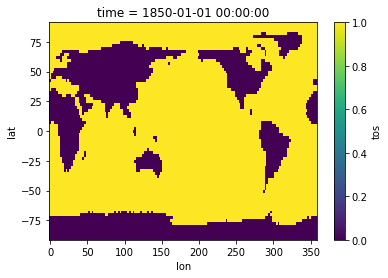

In [26]:
da_mask.plot()

In [27]:
used_memory()

used 1506.210938 MB


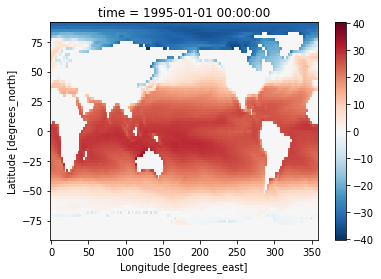

In [28]:
time1 = '1995-01'
(ds_atm['TS']*da_mask).sel(time=time1).plot()

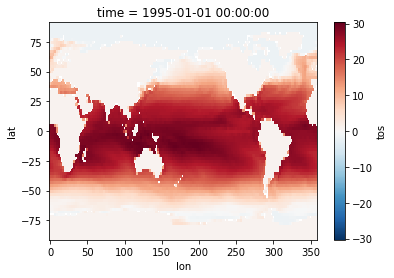

In [29]:
da_tos.sel(time=time1).plot()

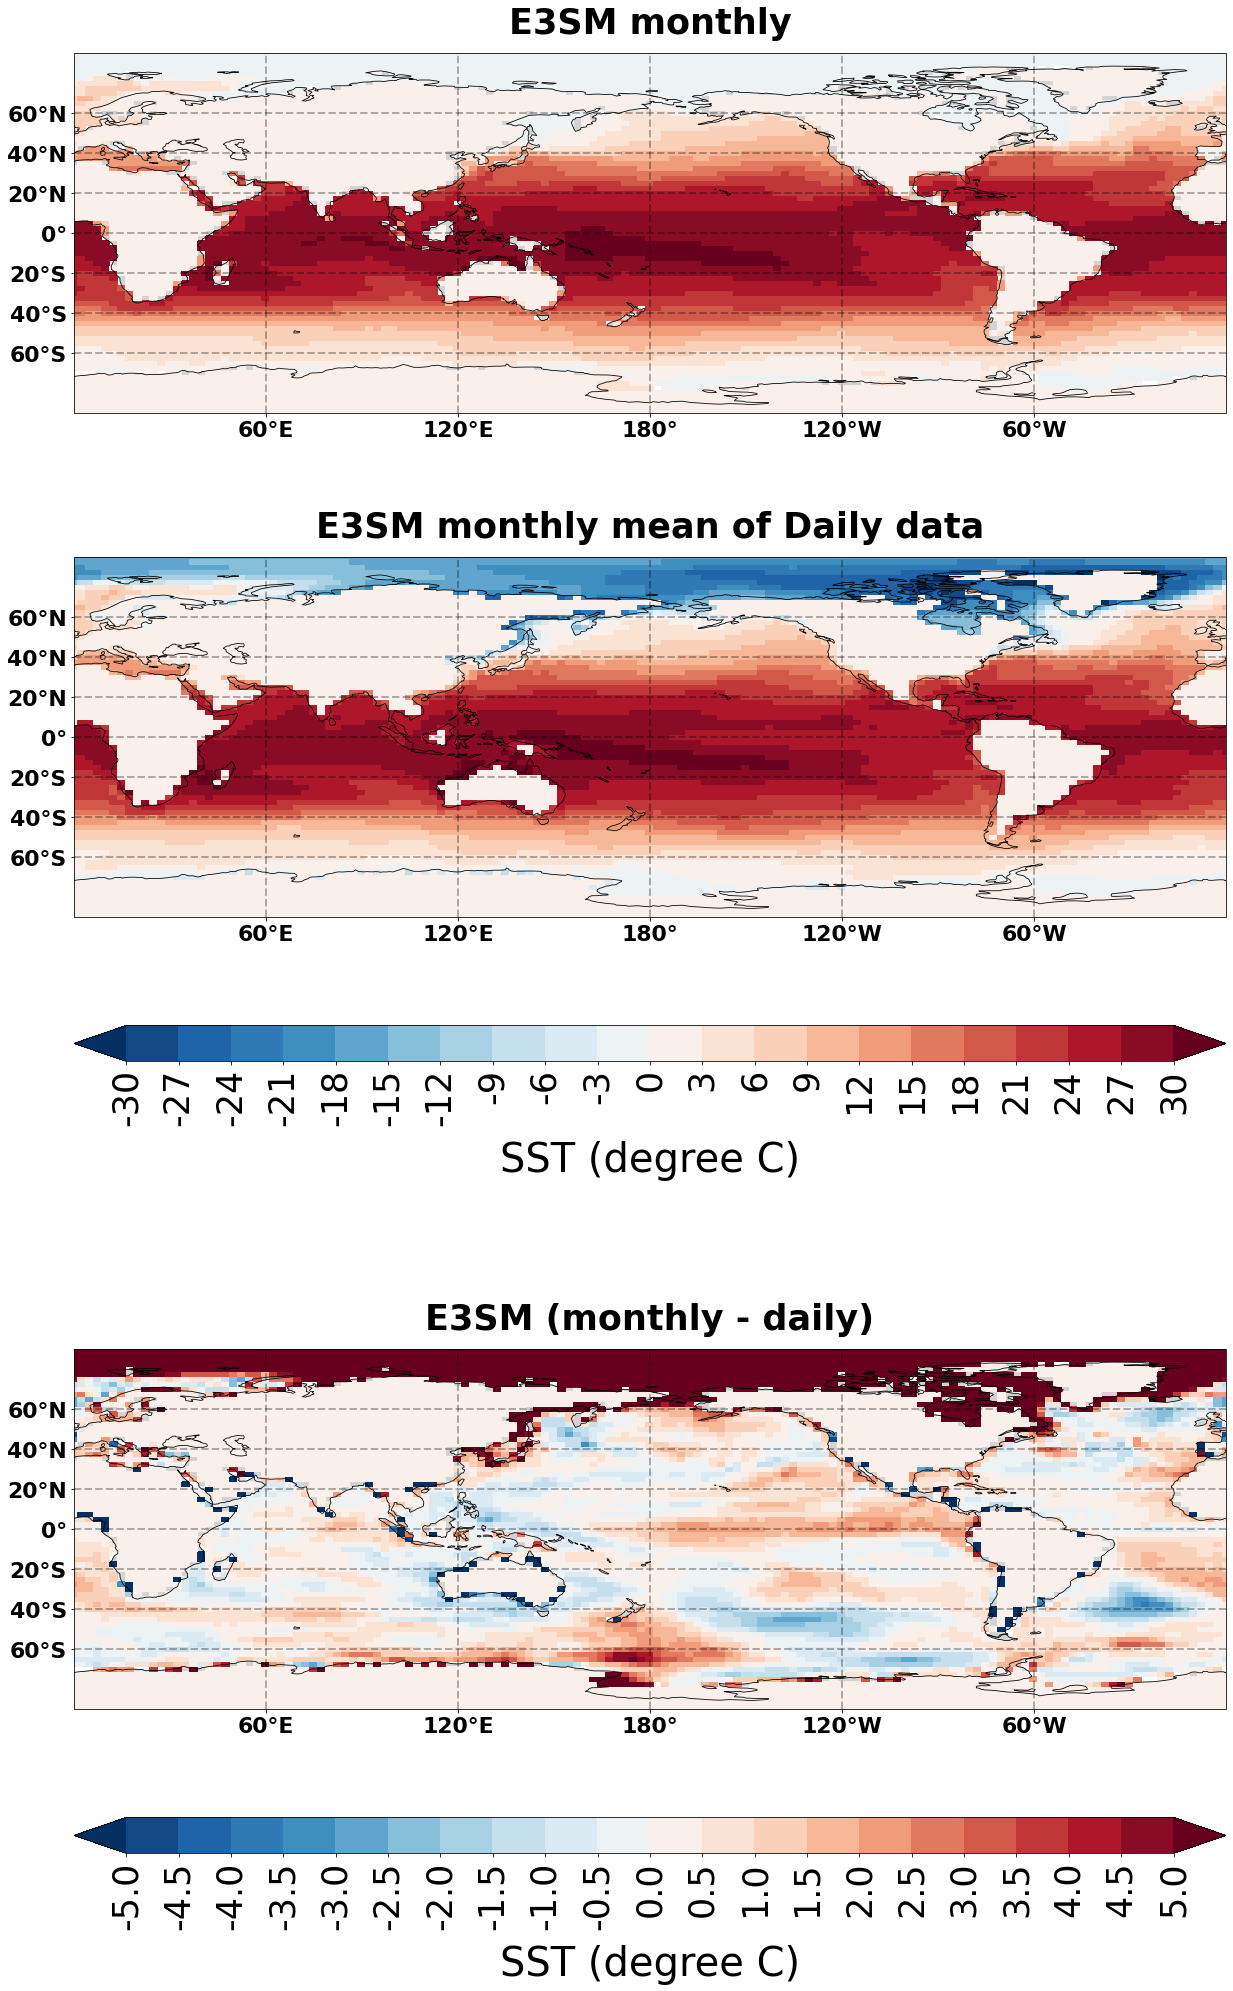

In [30]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7
level = np.linspace(-30, 30, 21)
dlevel = np.linspace(-5, 5, 21)

time='2014-01-01'


######################################## plotting ############################################
nmodel = 0
ax2 = fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im = (da_tos.sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',y='lat',
                            ax=ax2, levels=level, 
                            extend='both', cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0.))

cb=im.colorbar
cb.remove()


# cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(level)
# cbar.set_ticklabels(["%0.2f"%(n) for n in level]) # 
# cbar.ax.tick_params(labelsize=35,rotation=45) 
# cbar.set_label(label='LTFLX/PRECT (Correlation)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')
ax2=None


######################################## plotting ############################################
nmodel = 1
ax2=fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(ds_atm['TS'].sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=level, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.0f"%(n) for n in level]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly mean of Daily data', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')



######################################## plotting ############################################
nmodel = 2
ax2=fig.add_axes([0,0-nmodel*devy-0.4,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_tos.sel(time=time)*da_mask-ds_atm['TS'].sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2-0.4,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.1f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM (monthly - daily)', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')

fig.savefig('../figure/E3SM_tos_comp.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


In [31]:
da_tos = da_tos.where((da_tos['time.year']>=1995)&(da_tos['time.year']<=2014),drop=True)
da_tos_mean = da_tos.mean(dim='time')
da_tos -= da_tos_mean
da_ts_mean = ds_atm['TS'].mean(dim='time')
ds_atm['TS'] -= da_ts_mean

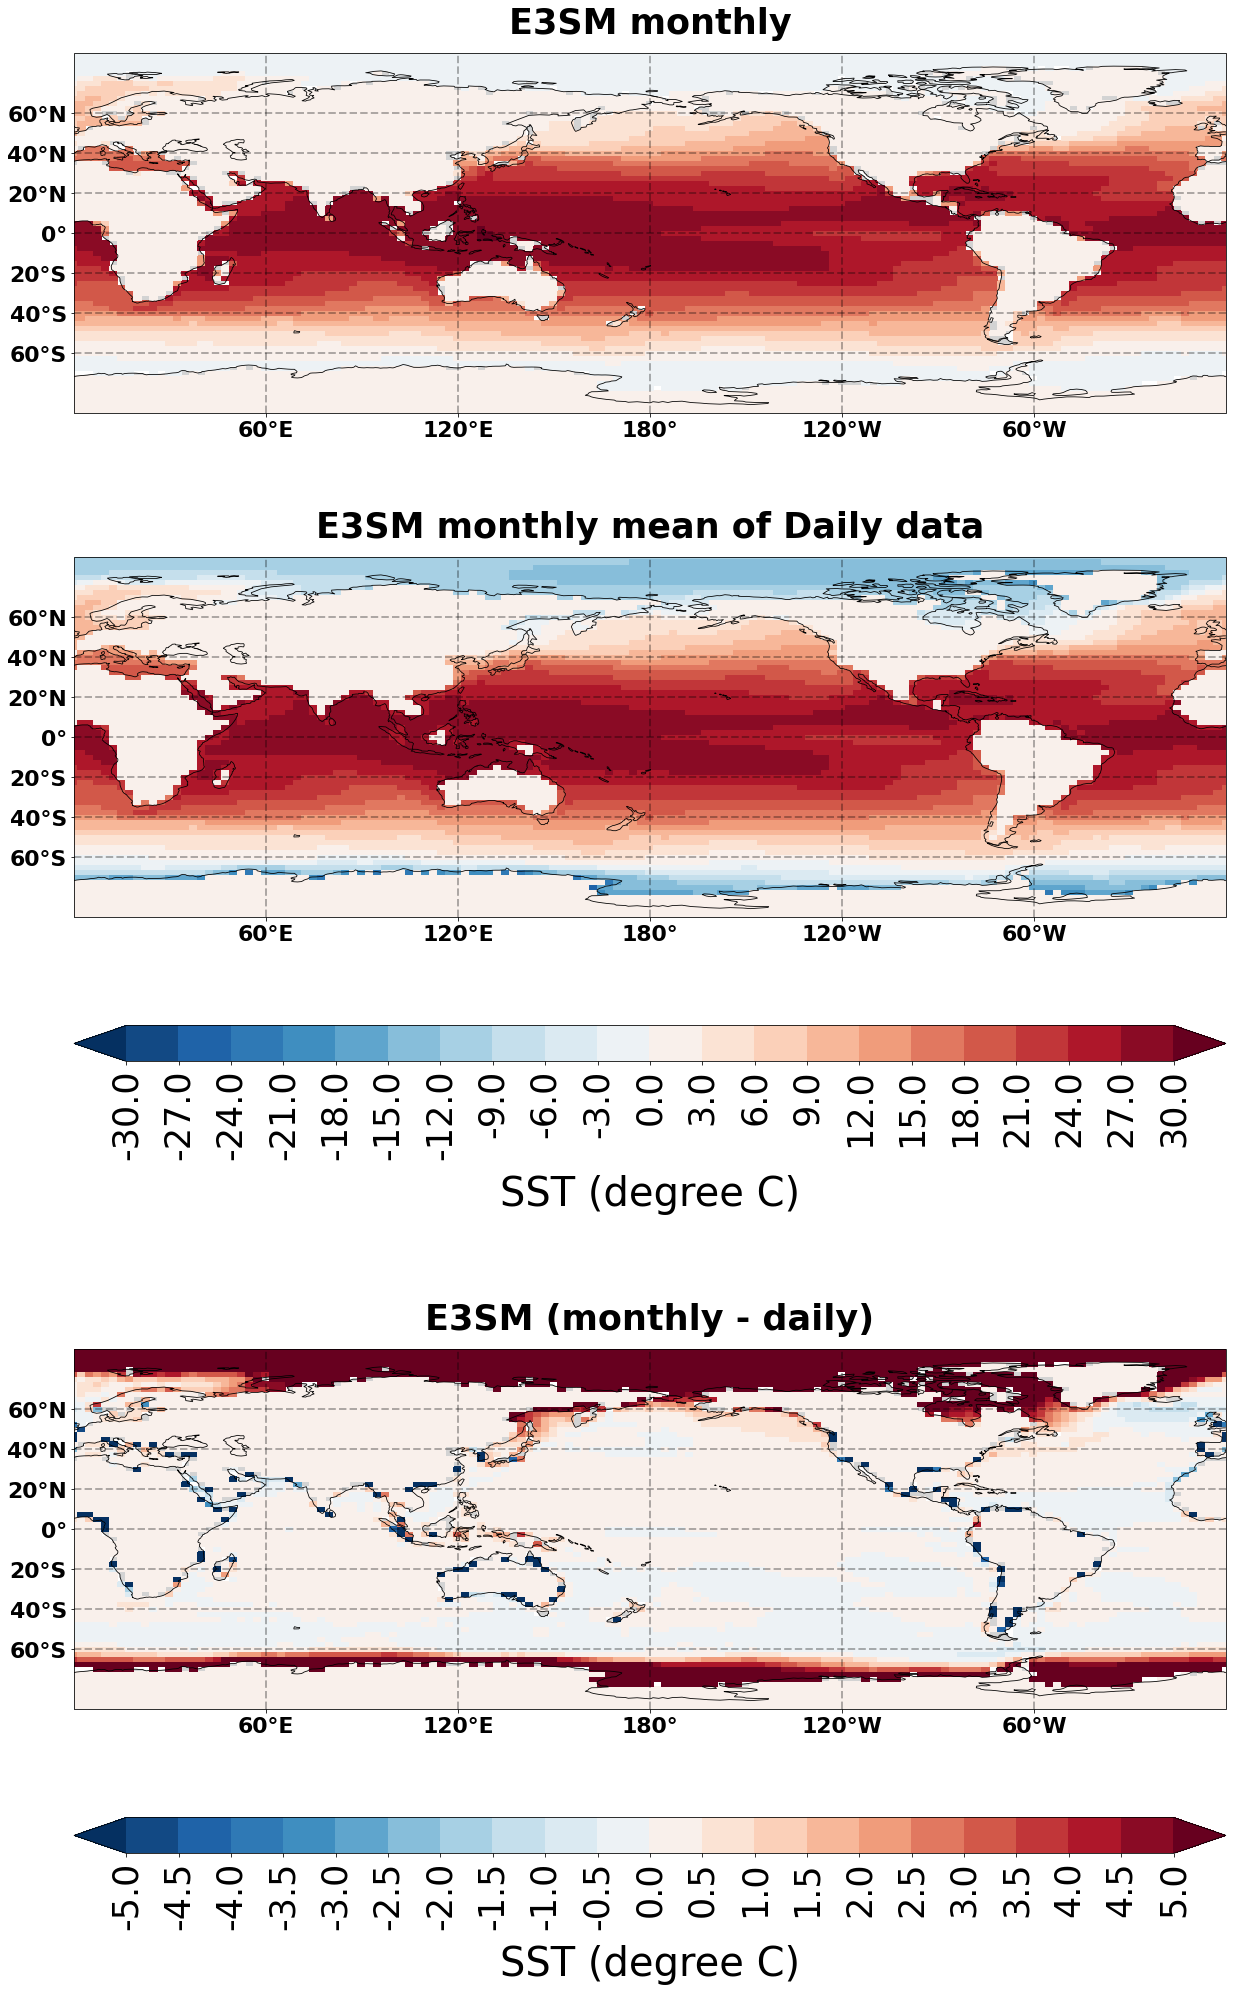

In [32]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7
level = np.linspace(-30, 30, 21)
dlevel = np.linspace(-5, 5, 21)


######################################## plotting ############################################
nmodel = 0
ax2 = fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im = (da_tos_mean*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',y='lat',
                            ax=ax2, levels=level, 
                            extend='both', cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0.))

cb=im.colorbar
cb.remove()


# cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(level)
# cbar.set_ticklabels(["%0.2f"%(n) for n in level]) # 
# cbar.ax.tick_params(labelsize=35,rotation=45) 
# cbar.set_label(label='LTFLX/PRECT (Correlation)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')
ax2=None


######################################## plotting ############################################
nmodel = 1
ax2=fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_ts_mean*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=level, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.1f"%(n) for n in level]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly mean of Daily data', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')



######################################## plotting ############################################
nmodel = 2
ax2=fig.add_axes([0,0-nmodel*devy-0.4,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_tos_mean*da_mask-da_ts_mean*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2-0.4,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.1f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM (monthly - daily)', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')


fig.savefig('../figure/E3SM_tos_comp_1995-2014mean.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

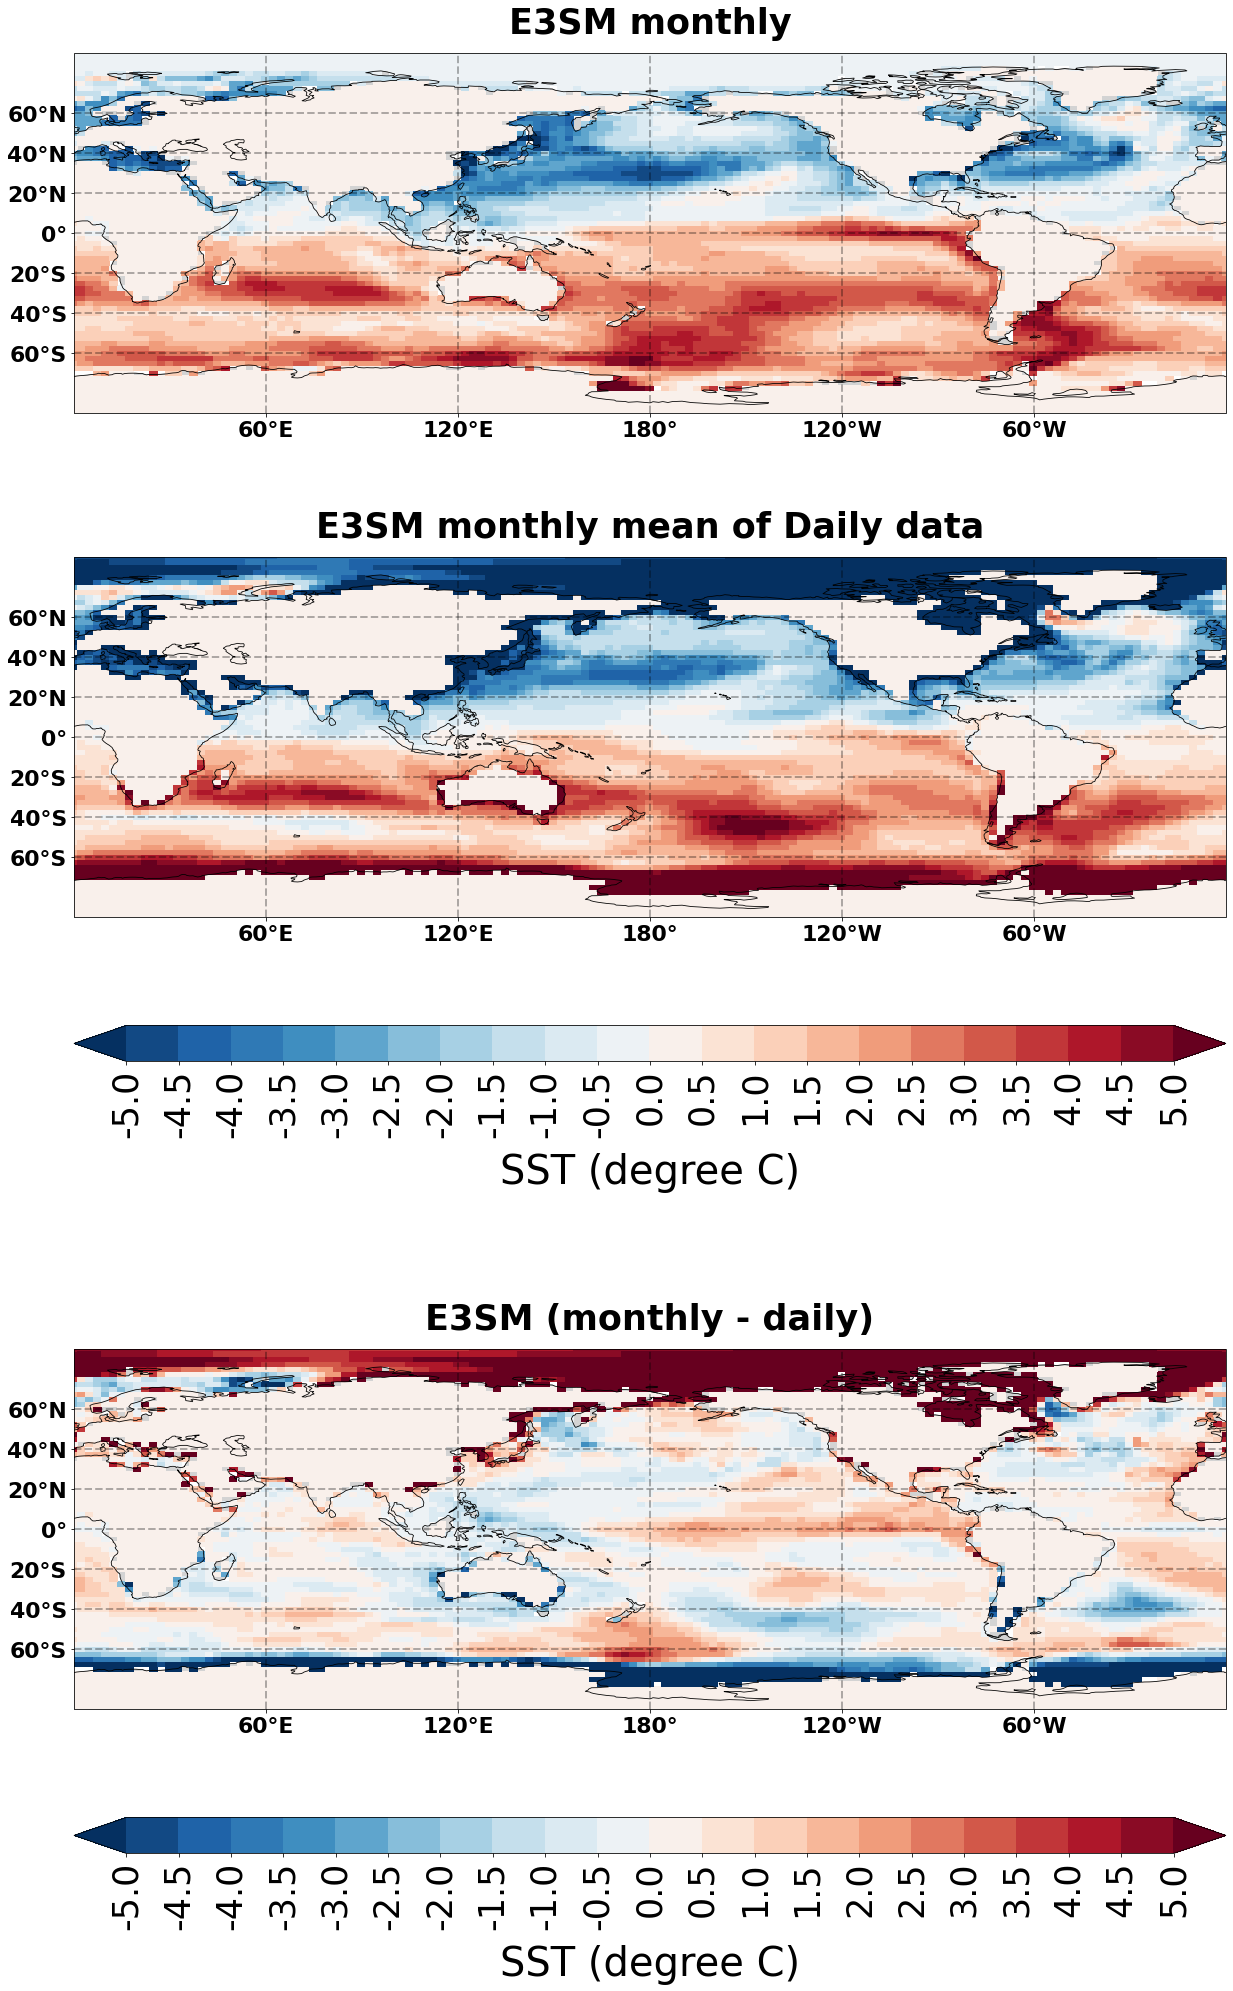

In [33]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7
level = np.linspace(-5, 5, 21)
dlevel = np.linspace(-5, 5, 21)

time='2014-01-01'


######################################## plotting ############################################
nmodel = 0
ax2 = fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im = (da_tos.sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',y='lat',
                            ax=ax2, levels=level, 
                            extend='both', cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0.))

cb=im.colorbar
cb.remove()


# cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(level)
# cbar.set_ticklabels(["%0.2f"%(n) for n in level]) # 
# cbar.ax.tick_params(labelsize=35,rotation=45) 
# cbar.set_label(label='LTFLX/PRECT (Correlation)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')
ax2=None


######################################## plotting ############################################
nmodel = 1
ax2=fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(ds_atm['TS'].sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=level, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.1f"%(n) for n in level]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly mean of Daily data', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')



######################################## plotting ############################################
nmodel = 2
ax2=fig.add_axes([0,0-nmodel*devy-0.4,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_tos.sel(time=time)*da_mask-ds_atm['TS'].sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2-0.4,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.1f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM (monthly - daily)', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')


fig.savefig('../figure/E3SM_tos_comp_1995-2014nomean.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

In [34]:
da_tos_season = da_tos.groupby('time.month').mean(dim='time')
da_tos_noseason = da_tos.groupby('time.month')-da_tos_season
da_ts_season = ds_atm['TS'].groupby('time.month').mean(dim='time')
da_ts_noseason = ds_atm['TS'].groupby('time.month')-da_ts_season

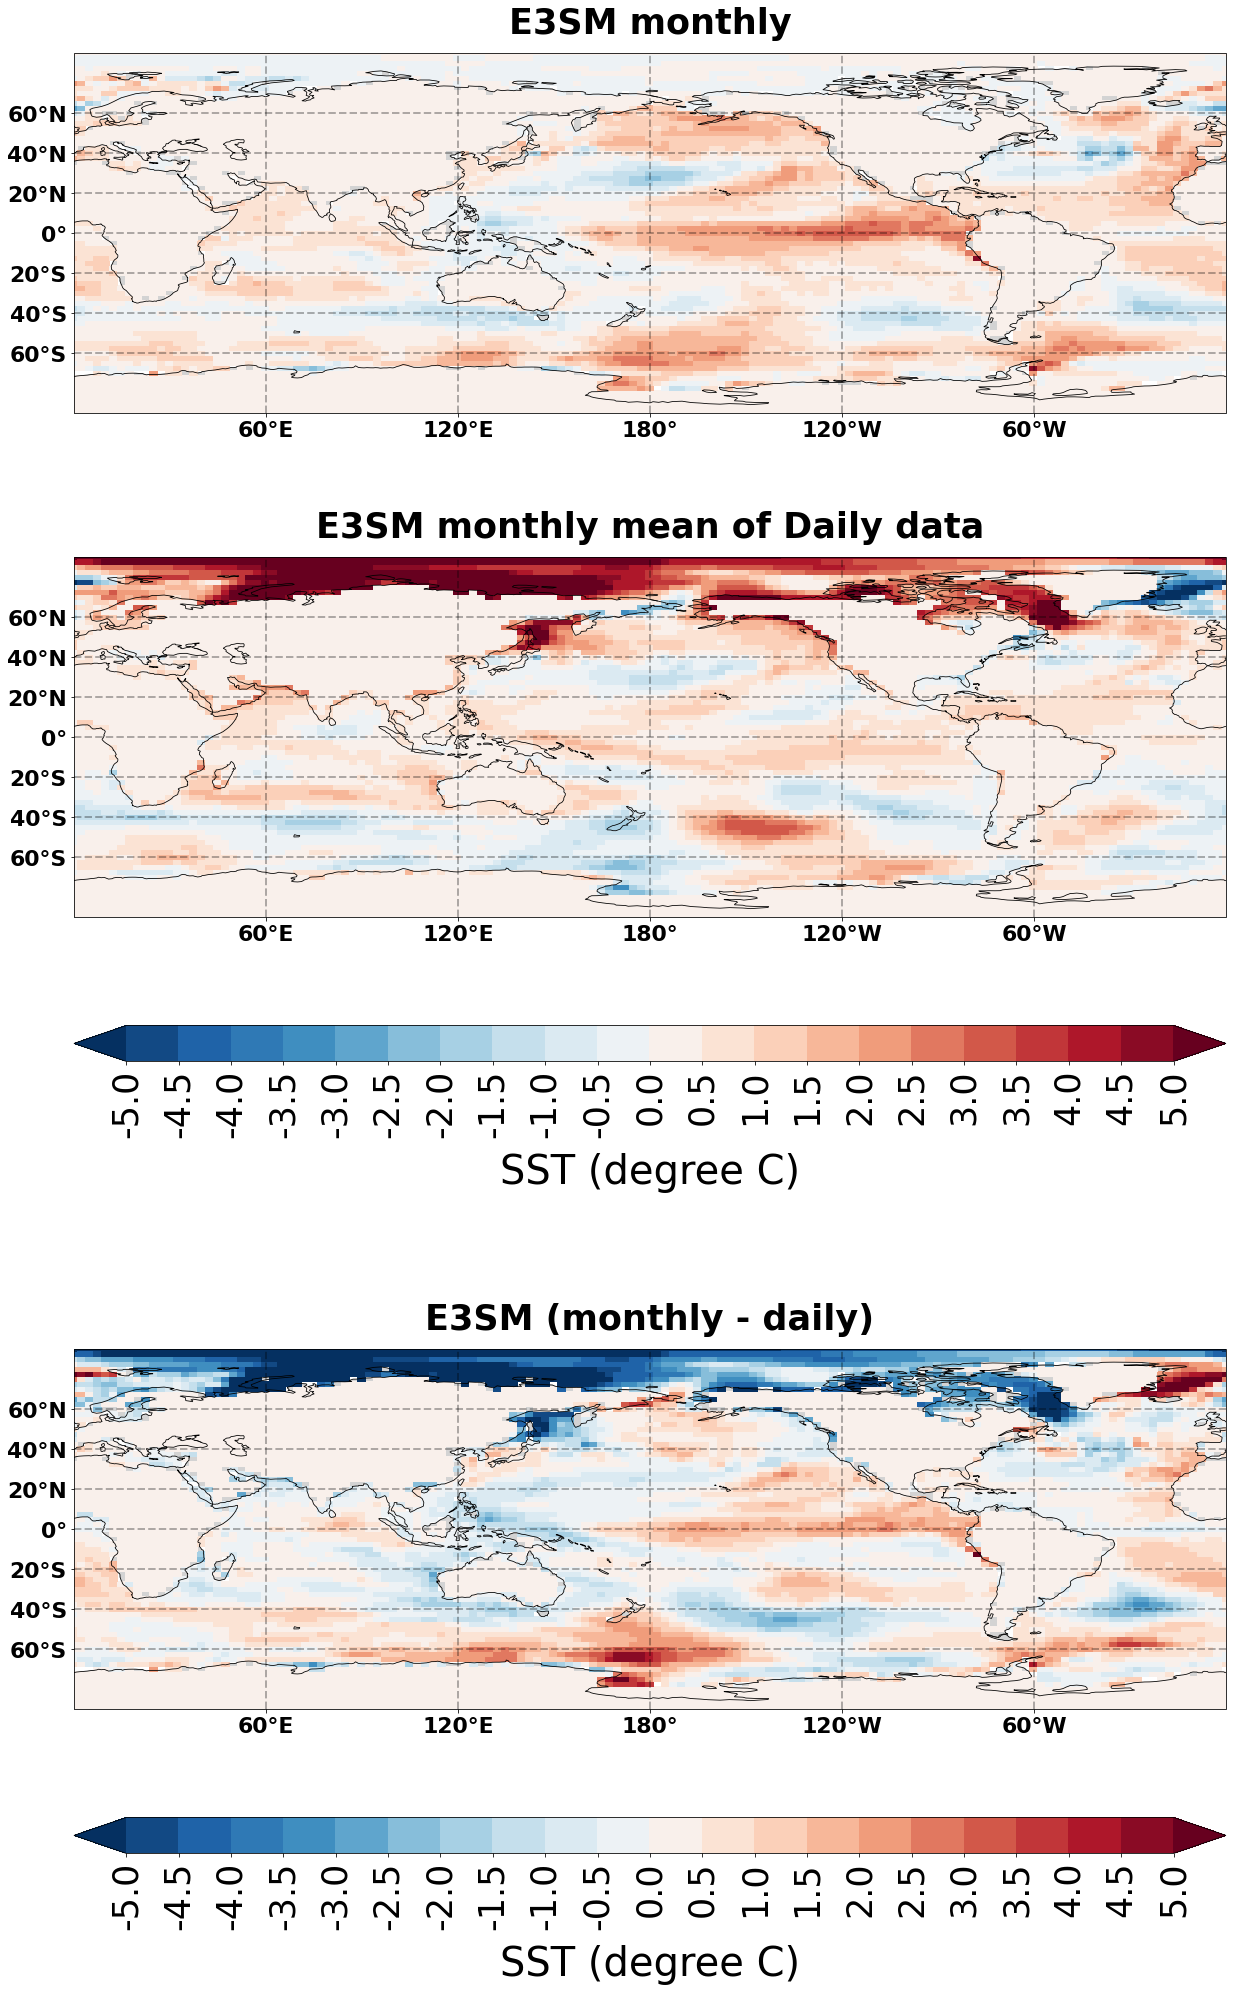

In [35]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7
level = np.linspace(-5, 5, 21)
dlevel = np.linspace(-5, 5, 21)

time='2014-01-01'


######################################## plotting ############################################
nmodel = 0
ax2 = fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im = (da_tos_noseason.sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',y='lat',
                            ax=ax2, levels=level, 
                            extend='both', cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0.))

cb=im.colorbar
cb.remove()


# cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(level)
# cbar.set_ticklabels(["%0.2f"%(n) for n in level]) # 
# cbar.ax.tick_params(labelsize=35,rotation=45) 
# cbar.set_label(label='LTFLX/PRECT (Correlation)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')
ax2=None


######################################## plotting ############################################
nmodel = 1
ax2=fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_ts_noseason.sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=level, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.1f"%(n) for n in level]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly mean of Daily data', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')



######################################## plotting ############################################
nmodel = 2
ax2=fig.add_axes([0,0-nmodel*devy-0.4,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_tos_noseason.sel(time=time)*da_mask-da_ts_noseason.sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2-0.4,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.1f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM (monthly - daily)', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')


fig.savefig('../figure/E3SM_tos_comp_noseason.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

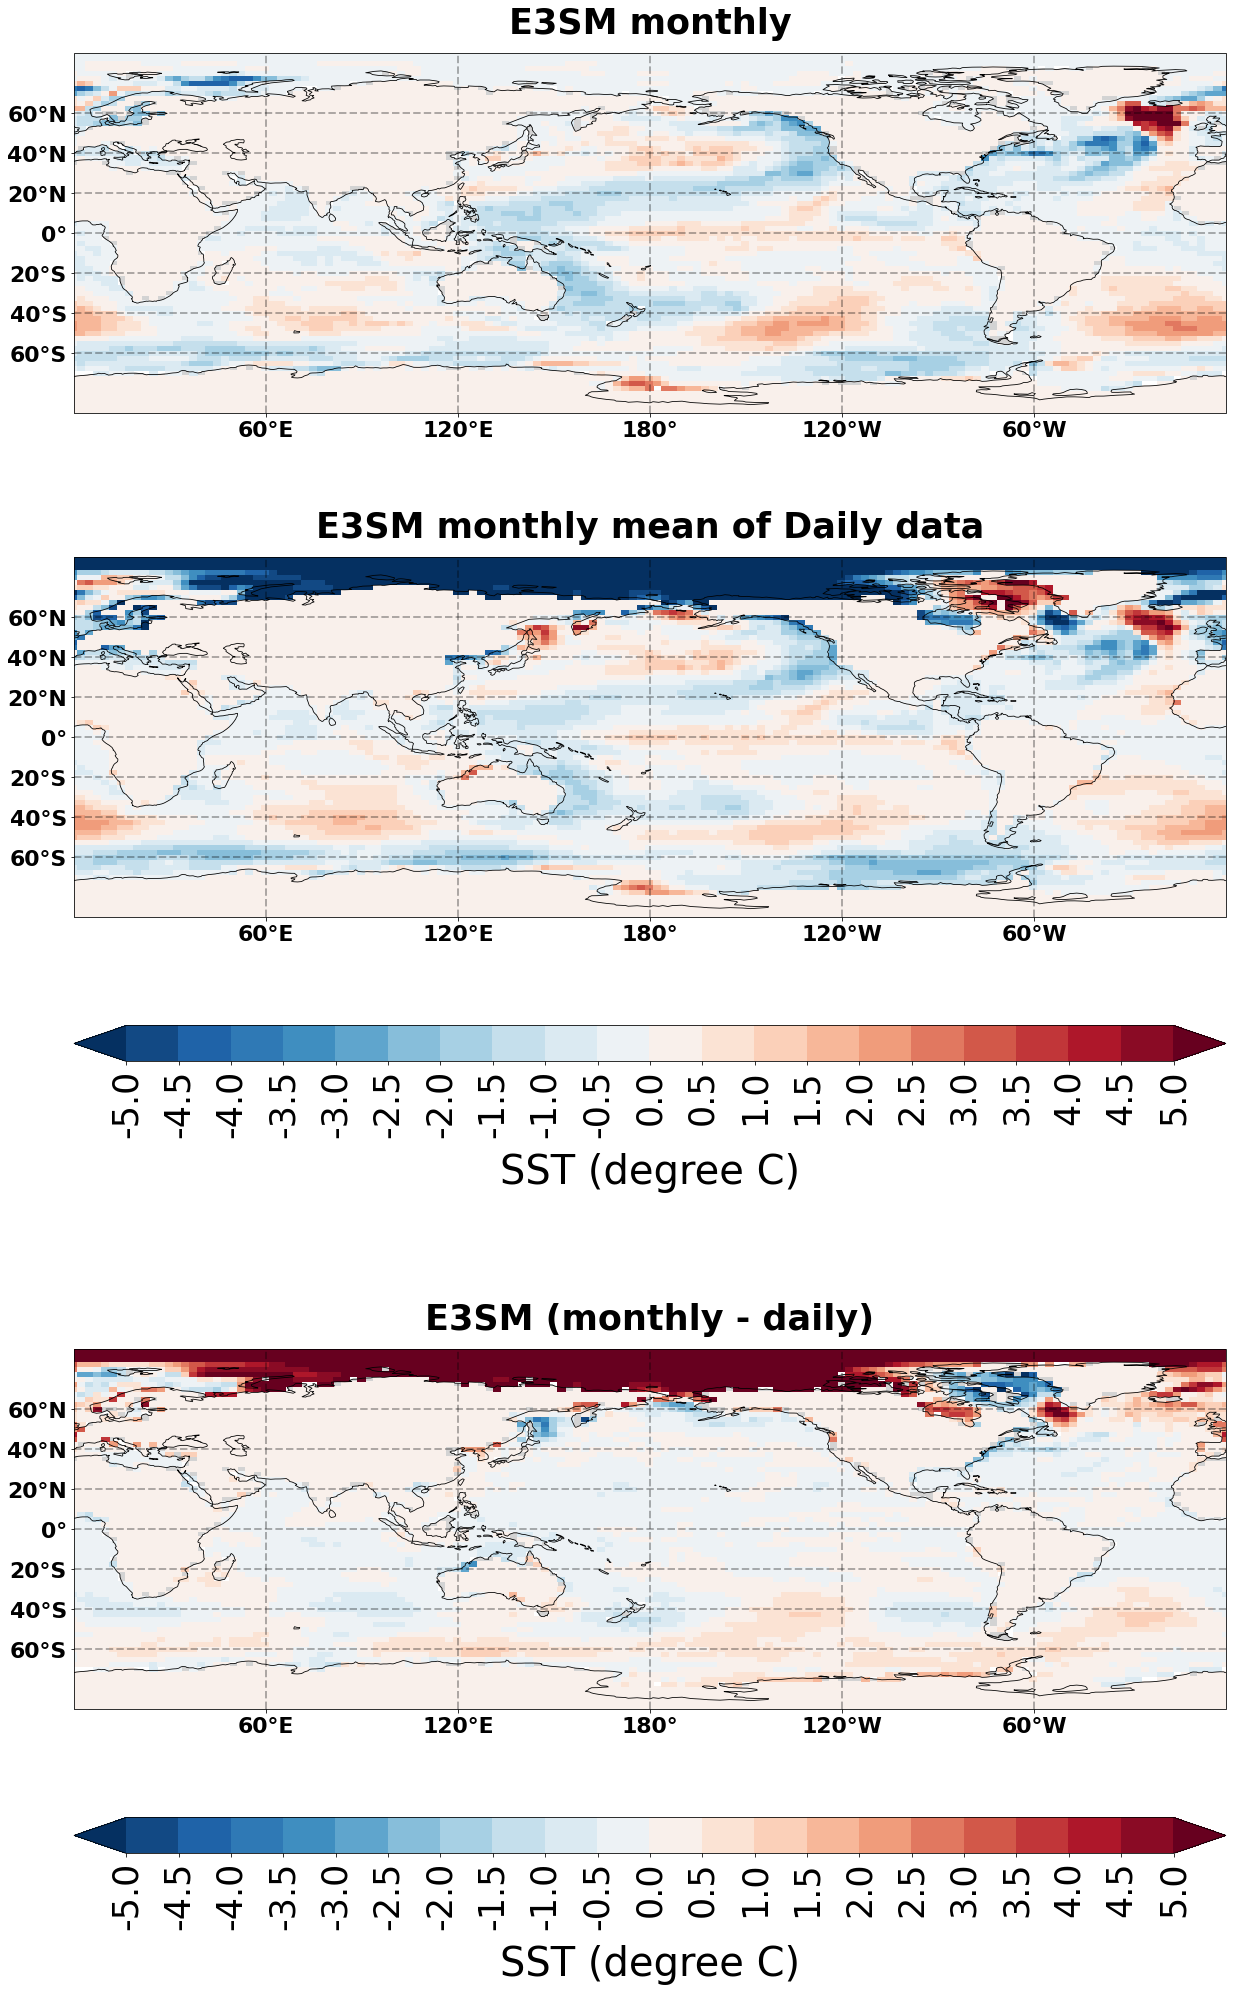

In [37]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7
level = np.linspace(-5, 5, 21)
dlevel = np.linspace(-5, 5, 21)

time='1995-01-01'


######################################## plotting ############################################
nmodel = 0
ax2 = fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im = (da_tos_noseason.sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',y='lat',
                            ax=ax2, levels=level, 
                            extend='both', cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0.))

cb=im.colorbar
cb.remove()


# cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(level)
# cbar.set_ticklabels(["%0.2f"%(n) for n in level]) # 
# cbar.ax.tick_params(labelsize=35,rotation=45) 
# cbar.set_label(label='LTFLX/PRECT (Correlation)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')
ax2=None


######################################## plotting ############################################
nmodel = 1
ax2=fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_ts_noseason.sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=level, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.1f"%(n) for n in level]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly mean of Daily data', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')



######################################## plotting ############################################
nmodel = 2
ax2=fig.add_axes([0,0-nmodel*devy-0.4,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_tos_noseason.sel(time=time)*da_mask-da_ts_noseason.sel(time=time)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2-0.4,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.1f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM (monthly - daily)', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')


fig.savefig('../figure/E3SM_tos_comp_noseason_start.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

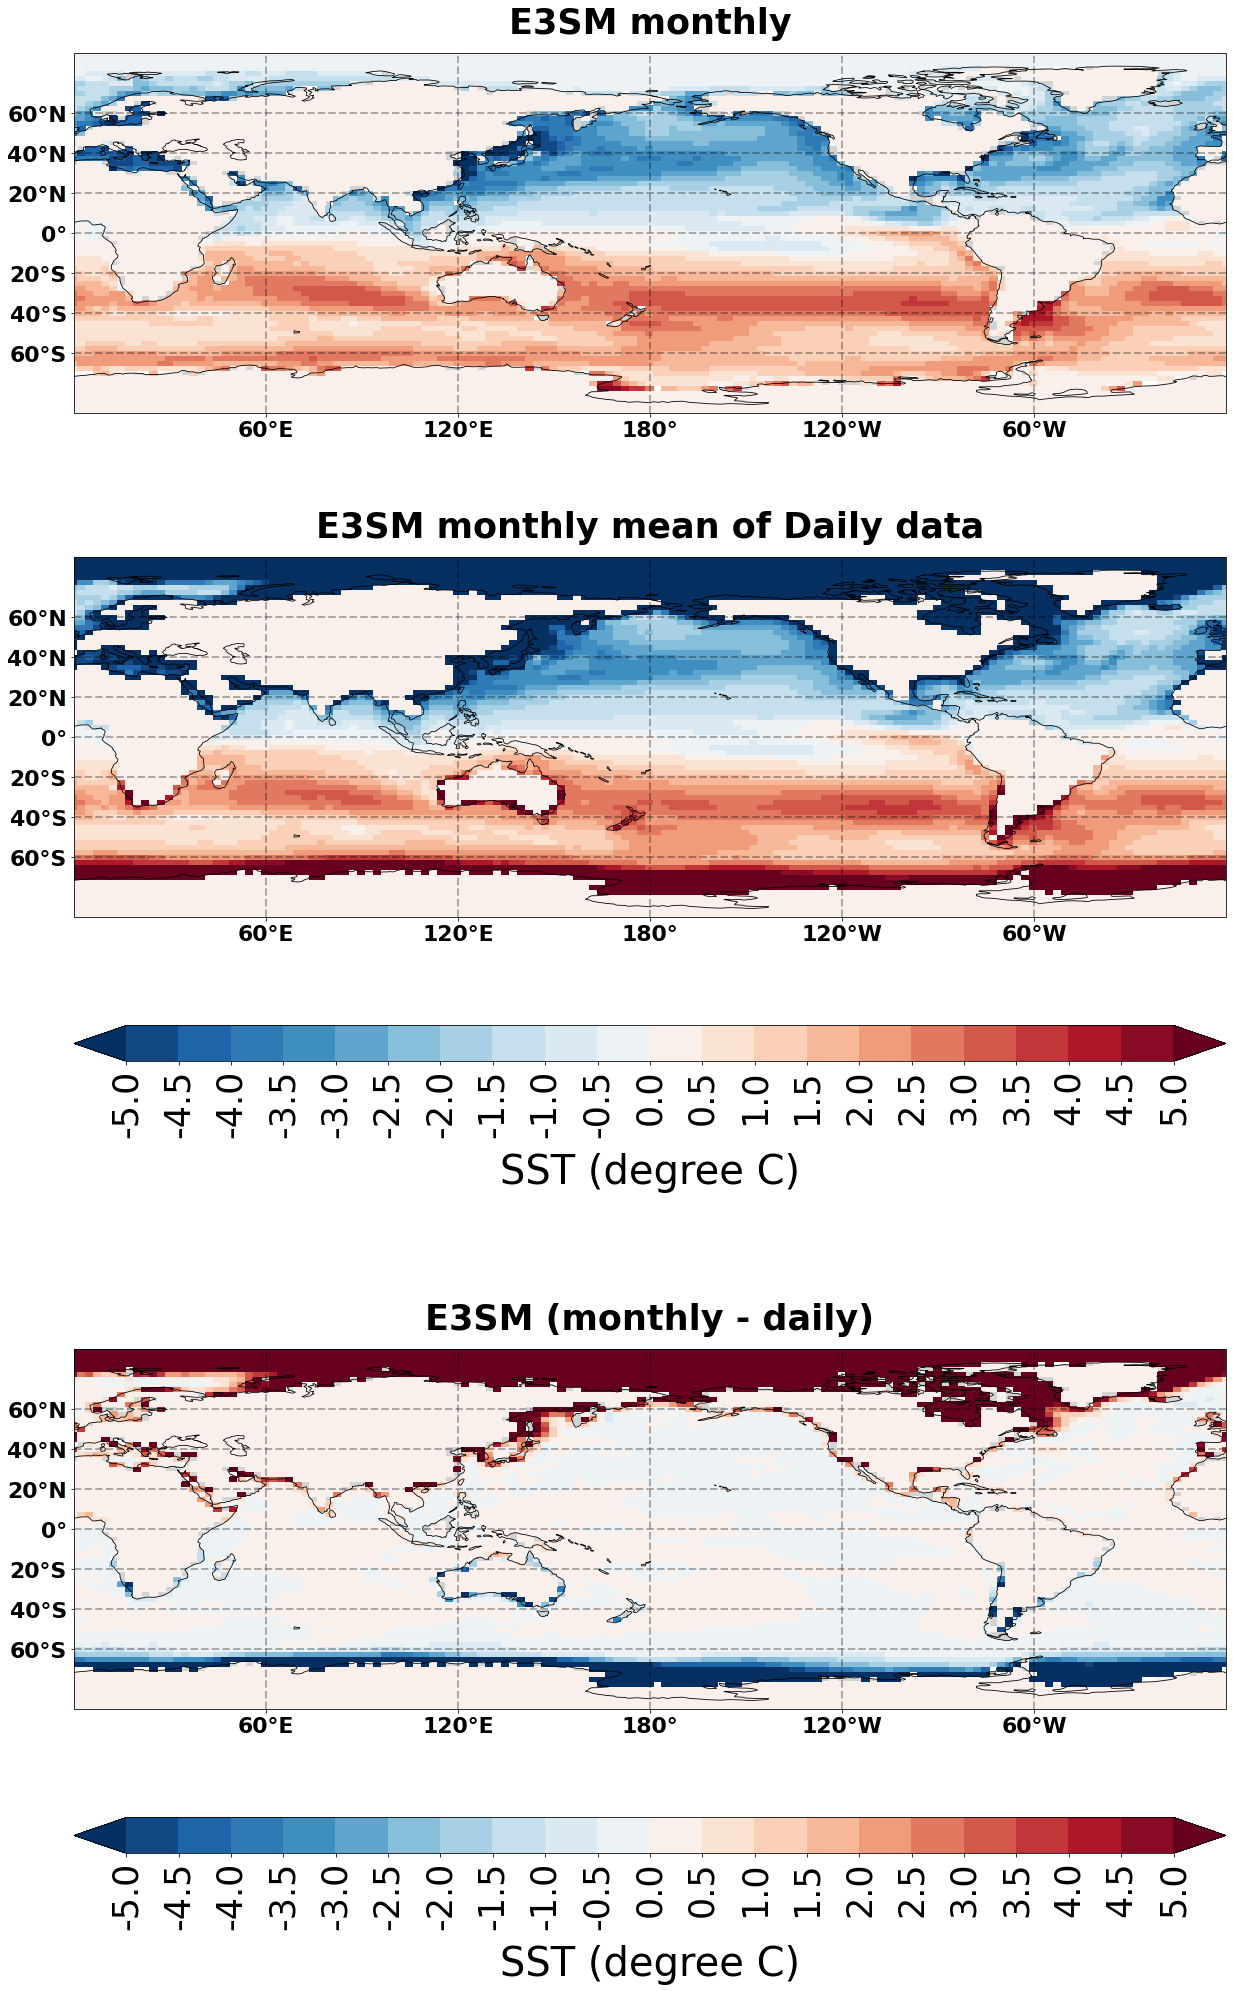

In [36]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(2,figsize=(20,10))
devy = 0.7
level = np.linspace(-5, 5, 21)
dlevel = np.linspace(-5, 5, 21)

month=1


######################################## plotting ############################################
nmodel = 0
ax2 = fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im = (da_tos_season.sel(month=month)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',y='lat',
                            ax=ax2, levels=level, 
                            extend='both', cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0.))

cb=im.colorbar
cb.remove()


# cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
# cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
# cbar.set_ticks(level)
# cbar.set_ticklabels(["%0.2f"%(n) for n in level]) # 
# cbar.ax.tick_params(labelsize=35,rotation=45) 
# cbar.set_label(label='LTFLX/PRECT (Correlation)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')
ax2=None


######################################## plotting ############################################
nmodel = 1
ax2=fig.add_axes([0,0-nmodel*devy,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_ts_season.sel(month=month)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=level, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(level)
cbar.set_ticklabels(["%0.1f"%(n) for n in level]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM monthly mean of Daily data', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')



######################################## plotting ############################################
nmodel = 2
ax2=fig.add_axes([0,0-nmodel*devy-0.4,1,0.5],projection=ccrs.PlateCarree(central_longitude=180))
im=(da_tos_season.sel(month=month)*da_mask-da_ts_season.sel(month=month)*da_mask).squeeze()\
             .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

cb=im.colorbar
cb.remove()


cbaxes=fig.add_axes([0,0-nmodel*devy-0.2-0.4,0.8,0.05])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.1f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=35,rotation=90) 
cbar.set_label(label='SST (degree C)',size=40, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')


ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-60,-40,-20,0,20,40,60], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-60,-40,-20,0,20,40,60], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('E3SM (monthly - daily)', color='black', weight='bold',size=35,pad=20)
ax2.set_aspect('auto')

fig.savefig('../figure/E3SM_tos_comp_season.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)

In [37]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
